In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from time import time
from matplotlib import dates as mdates
from datetime import datetime, timedelta
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (15,5)

In [2]:
tram_delays_raw = pd.DataFrame()
for filename in os.listdir('./data'):
    tram_delays_raw = tram_delays_raw.append(pd.read_csv(os.path.join('./data', filename)))
    #break

In [3]:
tram_delays_df = pd.DataFrame.copy(tram_delays_raw)
tram_delays_df['time'] = pd.to_datetime(tram_delays_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
tram_delays_df['hour'] = tram_delays_df['time'].map(lambda x: x.hour)
tram_delays_df['time_of_day'] = tram_delays_df['hour'].map(lambda x: 'night' if x < 5 or x > 23 else ('morning' if x < 10 else ('noon' if x < 14 else ('afternoon' if x < 19 else 'evening'))))
tram_delays_df['time'] = [x.replace(year=2000, month=1, day=1, second=0, microsecond=0) for x in tram_delays_df['time']]
tram_delays_df = tram_delays_df.sort_values(by=['time'])

In [4]:
tram_delays_df.head(10)

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay,hour,time_of_day
1057113,1057113,6352185295672180859,Kombinat,22,6351558574044844303,Os.Kolorowe,2000-01-01,1,1,0,night
1996949,1996949,6352185295672180860,Kombinat,22,6351558574044832787,Plac Centralny im. R.Reagana,2000-01-01,2,-1,0,night
1996950,1996950,6352185295672181371,Nowy Bieżanów P+R,3,6351558574044460055,Nowy Prokocim,2000-01-01,2,0,0,night
219153,219153,6352185295672180880,Kombinat,22,6351558574044848399,Ofiar Dąbia,2000-01-01,1,0,0,night
1996952,1996952,6352185295672180876,Kombinat,22,6351558574044836883,Starowiślna,2000-01-01,2,0,0,night
2395374,2395374,6352185295672180871,Kombinat,22,6351558574047761683,Starowiślna,2000-01-01,3,0,0,night
2661696,2661696,6352185295672180899,Kombinat,22,6351558574044840463,Klasztorna,2000-01-01,2,9,0,night
1996960,1996960,6352185295672181671,Zajezdnia Nowa Huta,73,6351558574045180941,TAURON Arena Kraków Wieczysta,2000-01-01,2,0,0,night
2370186,2370186,6352185295672180856,Kombinat,22,6351558574044846865,Os.Kolorowe,2000-01-01,2,1,0,night
2370189,2370189,6352185295672181383,Nowy Bieżanów P+R,3,6351558574044461847,Ćwiklińskiej,2000-01-01,2,-1,0,night


In [5]:
print(len(tram_delays_df))
aggregate_columns = ['stopName', 'patternText', 'direction']
grouped_tram_delays = tram_delays_df.groupby(aggregate_columns)
grouped_tram_delays = pd.DataFrame(grouped_tram_delays.filter(lambda x: len(x) > (len(tram_delays_df)/500)))
print(len(grouped_tram_delays.groupby(aggregate_columns)))

14955495
21


C:\Users\krzyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


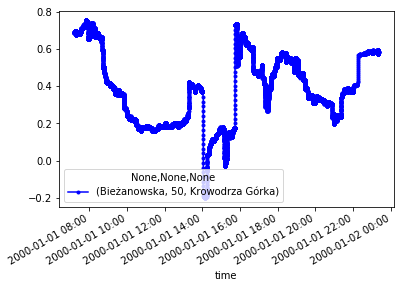

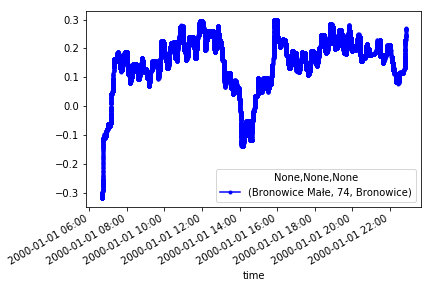

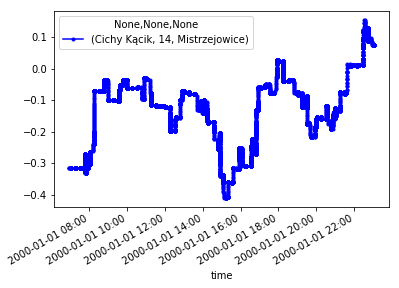

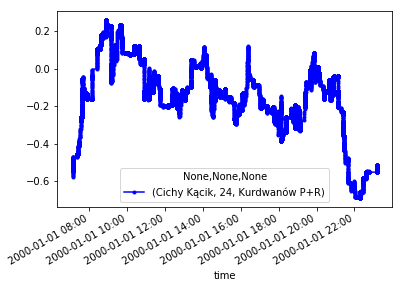

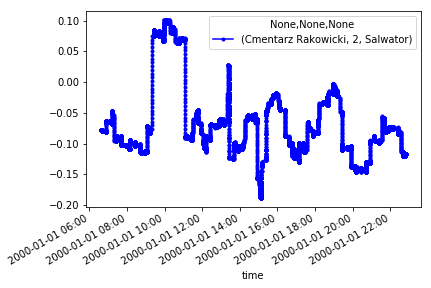

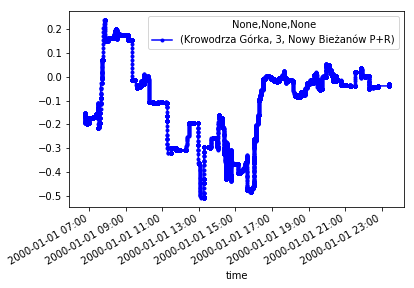

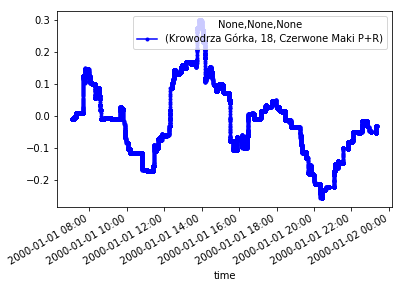

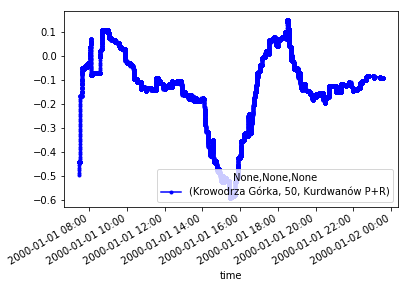

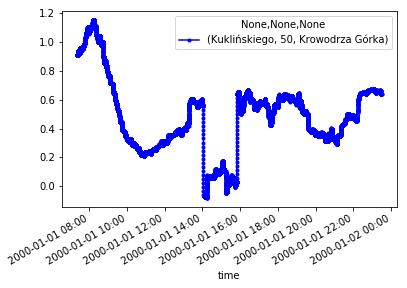

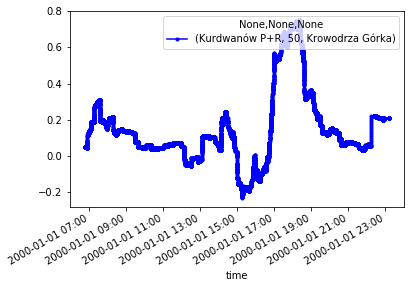

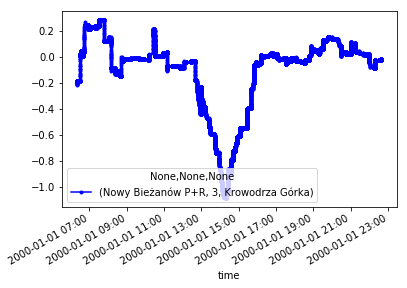

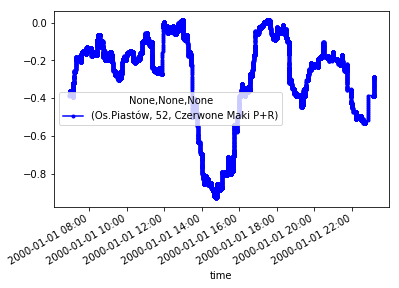

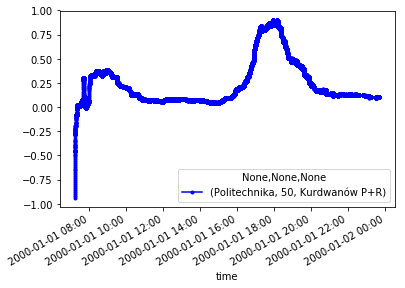

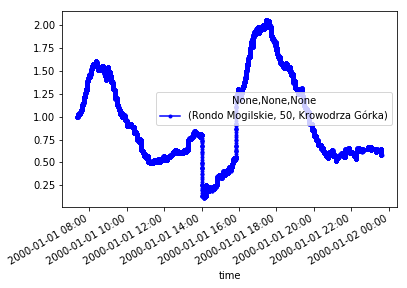

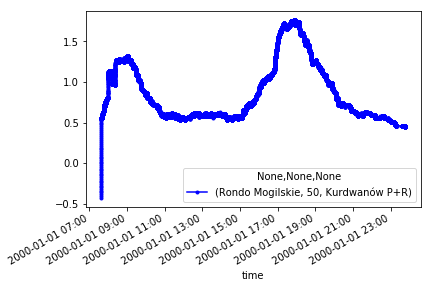

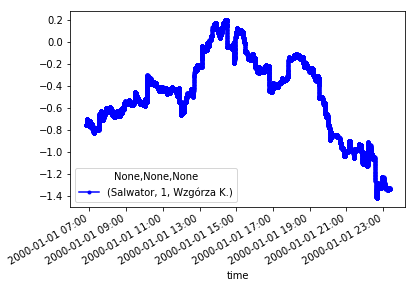

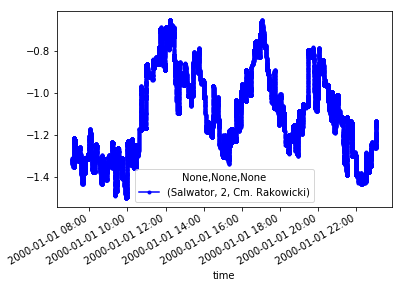

In [6]:
counter = 0
for key, grp in grouped_tram_delays.groupby(aggregate_columns):
    if len(grp['time'].values) > 100:
        grp['rolling_mean_delay'] = grp['delay'].rolling(int(len(grp['time'].values)/10)).mean()
        fig, ax = plt.subplots(1)
        grp.plot(ax=ax, style='.-', x='time', y='rolling_mean_delay', color='b', label=key)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.show()
        counter = counter + 1;
        if(counter > 16):
            break

In [7]:
def str_to_int_token(input_list):
    unique_list = list(set(input_list))
    out_list = [unique_list.index(x) for x in input_list]
    return out_list

In [8]:
grouped_tram_delays['direction'] = str_to_int_token(list(grouped_tram_delays['direction']))
grouped_tram_delays['stopName'] = str_to_int_token(list(grouped_tram_delays['stopName']))
grouped_tram_delays['time'] = str_to_int_token(list(grouped_tram_delays['time']))
grouped_tram_delays['time_of_day'] = str_to_int_token(list(grouped_tram_delays['time_of_day']))
feature_names = ['vehicleId', 'direction', 'patternText', 'tripId', 'stopName', 'time', 'day_of_week', 'hour', 'time_of_day']

grouped_tram_delays.head(10)
# grupy z dużą liczbą punktów -> poprawa z 3.5 na 2.43
# dodanie godzin i pór dnia -> poprawa na 2.42
# większy zbiór danych -> pogorszenie do 2.98
#autoregressive model
#korelacja
#dla 1 lini
#feature eng

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay,hour,time_of_day
1664324,1664324,6352185295672181661,7,50,6351558574045613570,2,617,5,-58,4,1
1408524,1408524,6352185295672181661,7,50,6351558574045613570,2,617,5,-58,4,1
1944945,1944945,6352185295672181661,7,50,6351558574045613570,2,617,5,-58,4,1
2581745,2581745,6352185295672181661,7,50,6351558574045613570,2,617,5,-58,4,1
1481138,1481138,6352185295672181661,7,50,6351558574045613570,2,282,5,-58,4,1
2175212,2175212,6352185295672181162,0,5,6351558574045345538,1,346,5,0,4,1
414550,414550,6352185295672181162,0,5,6351558574045345538,1,346,5,0,4,1
1436351,1436351,6352185295672180855,4,52,6351558574044977666,0,346,1,0,4,1
2117315,2117315,6352185295672181190,0,5,6351558574045343234,1,346,5,0,4,1
1326421,1326421,6352185295672180883,4,52,6351558574044963330,0,346,2,0,4,1


In [9]:
Xtr, Xv, ytr, yv = train_test_split(grouped_tram_delays[feature_names].values, grouped_tram_delays['delay'].values, test_size=0.2, random_state=1987)

In [10]:
start = time()
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 30,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=5,
                  maximize=False, verbose_eval=1)
end = time()
print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:3.03271	valid-rmse:3.12703
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:3.01289	valid-rmse:3.10813
[2]	train-rmse:2.99419	valid-rmse:3.09048
[3]	train-rmse:2.98974	valid-rmse:3.08633
[4]	train-rmse:2.91194	valid-rmse:3.01606
[5]	train-rmse:2.91096	valid-rmse:3.01511
[6]	train-rmse:2.91016	valid-rmse:3.0143
[7]	train-rmse:2.90534	valid-rmse:3.00944
[8]	train-rmse:2.90085	valid-rmse:3.0052
[9]	train-rmse:2.89051	valid-rmse:2.99466
[10]	train-rmse:2.88948	valid-rmse:2.9938
[11]	train-rmse:2.88942	valid-rmse:2.99373
[12]	train-rmse:2.88375	valid-rmse:2.98761
[13]	train-rmse:2.88373	valid-rmse:2.98759
[14]	train-rmse:2.88372	valid-rmse:2.98758
[15]	train-rmse:2.88372	valid-rmse:2.98756
[16]	train-rmse:2.88352	valid-rmse:2.98741
[17]	train-rmse:2.88271	valid-rmse:2.98659
[18]	train-rmse:2.83345	valid-rmse:2.94643
[19]	train-rmse:2.77551	valid-rmse:2.8946
[20]	train

In [50]:
df = grouped_tram_delays.loc[grouped_tram_delays['patternText'] == 50]
df = df[~df.index.duplicated()]
df = df.loc[df['stopName'] == 2]
df = df[~df.index.duplicated()]
df = df.loc[df['direction'] == 7]
df = df[~df.index.duplicated()]

In [61]:
df

,time,delay
1664324,617,-58
1408524,617,-58
1944945,617,-58
2581745,617,-58
1481138,282,-58
562757,220,-1
2925474,220,-1
2112875,220,-1
2190145,220,-1
1715781,220,-1


In [52]:
from pandas.plotting import lag_plot

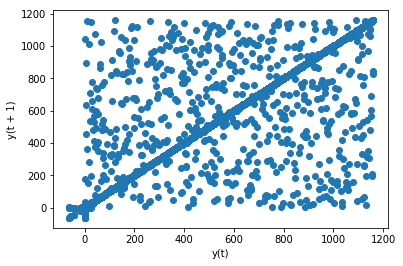

In [65]:
series = df[['time', 'delay']]
lag_plot(series)
pyplot.show()

In [66]:
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

In [67]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
result = dataframe.corr()
print(result)

          0         1         0         1
0  1.000000 -0.006324  0.986813 -0.006550
1 -0.006324  1.000000 -0.006094  0.534648
0  0.986813 -0.006094  1.000000 -0.006322
1 -0.006550  0.534648 -0.006322  1.000000


In [68]:
from pandas import Series
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

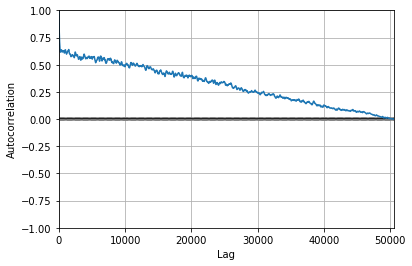

In [69]:
autocorrelation_plot(series)
pyplot.show()